In [1]:
%matplotlib inline

import pandas as pd
import geopandas
import json
from shapely.geometry import Point
import folium
import difflib
from geopy.distance import vincenty

# Analyse comparative des quantités de points d'arrêts

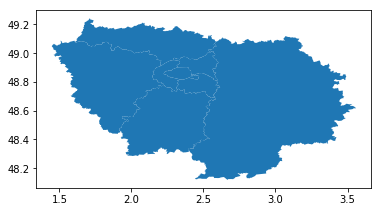

In [2]:
#contenus géographiques qu'on utilisera
zones = geopandas.read_file('ref_data/idf_departements.geojson', driver='GeoJSON')
zones = zones[['name', 'geometry']]
zones.plot()

In [3]:
#on charge les données
osm_stoppoints = pd.read_csv("../data/osm-transit-extractor_stop_points.csv", dtype=str)
gtfs_stoppoints = pd.read_csv("../data/gtfs_stops.txt", dtype=str)
gtfs_stoppoints = gtfs_stoppoints[gtfs_stoppoints['location_type'] == '0'] #on retire les zones d'arrêts

#on ajoute la dimension géographique
crs = {'init': 'epsg:4326'}
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['stop_lon']),float(row['stop_lat']))

gtfs_stoppoints['geometry'] = gtfs_stoppoints.apply(gtfs_lat_lon_to_geom, axis=1)
gtfs_stoppoints.drop('stop_lon', axis=1, inplace=True)
gtfs_stoppoints.drop('stop_lat', axis=1, inplace=True)

def osm_lat_lon_to_geom(row):
    return Point(float(row['lon']),float(row['lat']))

osm_stoppoints['geometry'] = osm_stoppoints.apply(osm_lat_lon_to_geom, axis=1)
osm_stoppoints.drop('lon', axis=1, inplace=True)
osm_stoppoints.drop('lat', axis=1, inplace=True)

osm_stops_geo = geopandas.GeoDataFrame(osm_stoppoints, crs=crs, geometry=osm_stoppoints.geometry)
gtfs_stops_geo = geopandas.GeoDataFrame(gtfs_stoppoints, crs=crs, geometry=gtfs_stoppoints.geometry)

#on calcule le nombre par département
gtfs_stoppoints_with_zones = geopandas.sjoin(gtfs_stops_geo, zones.copy(), op='within')
counts_gtfs_stops = gtfs_stoppoints_with_zones.groupby('name').size()
zones_with_gtfs_stops_count = zones[['name', 'geometry']].merge(counts_gtfs_stops.reset_index(name='nb_stoppoints_officiel'))

osm_stoppoints_with_zones = geopandas.sjoin(osm_stops_geo, zones.copy(), op='within')
counts_osm_stops = osm_stoppoints_with_zones.groupby('name_right').size()
zones_with_stoppoints_count = zones_with_gtfs_stops_count.merge(counts_osm_stops.reset_index(name='nb_stoppoints_osm'), left_on="name", right_on='name_right')
zones_with_stoppoints_count.drop('name_right', axis=1, inplace=True)

#on calcule le pourcentage de couverture d'OSM par rapport à l'officiel
zones_with_stoppoints_count["couverture_stoppoints_osm"] = zones_with_stoppoints_count["nb_stoppoints_osm"] * 100.0 / zones_with_stoppoints_count["nb_stoppoints_officiel"]

#TODO : histogramme de la couverture en pourcentage par département
zones_with_stoppoints_count

,name,geometry,nb_stoppoints_officiel,nb_stoppoints_osm,couverture_stoppoints_osm
0,Seine-et-Marne,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",8281,4588,55.403937
1,Seine-Saint-Denis,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",4033,2581,63.997025
2,Essonne,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",5934,3671,61.863836
3,Val-d'Oise,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",4769,2980,62.486895
4,Hauts-de-Seine,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",3748,2773,73.986126
5,Yvelines,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",8332,3956,47.479597
6,Val-de-Marne,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",3157,2688,85.144124
7,Paris,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",3061,2402,78.471088


In [4]:
m = folium.Map([48.8566, 2.3429], zoom_start=9, tiles="OpenStreetMap")
m.choropleth(geo_data=zones_with_stoppoints_count, data=zones_with_stoppoints_count, columns=['name', 'couverture_stoppoints_osm'],
             key_on='feature.properties.name', fill_color='YlOrRd', highlight=True)


m

Pourcentage de couverture global sur l'Île-de-France en points d'arrêts:

In [5]:
len(osm_stoppoints) * 100.0 / len(gtfs_stoppoints)

61.55064430206608

NB : les données OSM sont déjà filtrées sur les bus, mais pas les données officielles

# Analyse comparative en utilisant les lignes desservies

In [6]:
# on charge les lignes dans les deux sources
gtfs_lines = pd.read_csv("../data/gtfs_routes.txt", dtype=str)
gtfs_lines = gtfs_lines[gtfs_lines['route_type'] == '3']

osm_lines = pd.read_csv("../data/osm-transit-extractor_lines.csv", dtype=str)
osm_lines = osm_lines[osm_lines['mode'] == 'bus']

Pourcentage de couverture en lignes de bus:

In [7]:
len(osm_lines) * 100.0 / len(gtfs_lines)

48.806218767351474

In [8]:
#préparation géographique des données officielles pour les routepoints
gtfs_routepoints = pd.read_csv("../data/opendata_routepoints.csv", dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)
    
crs = {'init': 'epsg:4326'}   
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['gtfs_stop_lon']),float(row['gtfs_stop_lat']))

gtfs_routepoints['geometry'] = gtfs_routepoints.apply(gtfs_lat_lon_to_geom, axis=1)

gtfs_geo = geopandas.GeoDataFrame(gtfs_routepoints, crs=crs, geometry=gtfs_routepoints.geometry)
#gtfs_geo.plot(markersize=0.5, figsize=(10, 10))

gtfs_routepoints_with_zones = geopandas.sjoin(gtfs_geo, zones.copy(), op='within')
counts_gtfs = gtfs_routepoints_with_zones.groupby('name').size()
zones_with_gtfs_count = zones.merge(counts_gtfs.reset_index(name='nb_stops_officiel'))

In [9]:
#préparation géographique des données OSM pour les routepoints
osm_routepoints = pd.read_csv("../data/osm_routepoints.csv", dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)
def osm_lat_lon_to_geom(row):
    return Point(float(row['osm_lon']),float(row['osm_lat']))

osm_routepoints['geometry'] = osm_routepoints.apply(osm_lat_lon_to_geom, axis=1)
osm_routepoints.drop('osm_lon', axis=1, inplace=True)
osm_routepoints.drop('osm_lat', axis=1, inplace=True)

osm_geo = geopandas.GeoDataFrame(osm_routepoints, crs=crs, geometry=osm_routepoints.geometry)
#osm_geo.plot(markersize=0.5, figsize=(10, 10))

osm_routepoints_with_zones = geopandas.sjoin(osm_geo, zones.copy(), op='within')
counts_osm = osm_routepoints_with_zones.groupby('name').size()
zones_with_routepoints_count = zones_with_gtfs_count.merge(counts_osm.reset_index(name='nb_stops_osm'))
zones_with_routepoints_count["couverture_osm"] = zones_with_routepoints_count["nb_stops_osm"] * 100.0 / zones_with_routepoints_count["nb_stops_officiel"]

#TODO : histogramme de la couverture en pourcentage par département
zones_with_routepoints_count

,name,geometry,nb_stops_officiel,nb_stops_osm,couverture_osm
0,Seine-et-Marne,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",26172,3482,13.304295
1,Seine-Saint-Denis,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",8442,2250,26.652452
2,Essonne,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",14284,3631,25.420050
3,Val-d'Oise,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",10288,3119,30.316874
4,Hauts-de-Seine,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",7792,3619,46.445072
5,Yvelines,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",22133,1652,7.463968
6,Val-de-Marne,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",7591,3452,45.474904
7,Paris,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",6835,4454,65.164594


In [10]:
m = folium.Map([48.8566, 2.3429], zoom_start=9, tiles="OpenStreetMap")
m.choropleth(geo_data=zones_with_routepoints_count, data=zones_with_routepoints_count, columns=['name', 'couverture_osm'],
             key_on='feature.properties.name', fill_color='YlGn', highlight=True)


m

Pourcentage global de couverture OSM sur l'Île-de-France en routepoints : 

In [11]:
len(osm_routepoints) * 100.0 / len(gtfs_routepoints)

24.645432634601164

In [12]:
#TODO : nombre moyen de terminus par ligne, pour OSM

#TODO : nombre moyen de terminus par ligne, pour le GTFS

# Analyse quantitative par réseau

TODO : faire une table de correspondance entre les réseaux des deux sources car on en écarte plus de la moitié parce que ça ne matche pas exactement

Et trouver un moyen sympa de le visualiser

In [13]:
osm_networks = pd.DataFrame(osm_routepoints.groupby('osm_network').size()).reset_index()
gtfs_networks = pd.DataFrame(gtfs_routepoints.groupby('gtfs_agency_name').size()).reset_index()
networks = gtfs_networks.merge(osm_networks, how='inner', right_on=['osm_network'], left_on=['gtfs_agency_name'])
networks.rename(columns={'0_x': 'gtfs_count', '0_y': 'osm_count'}, inplace=True)
networks.drop('osm_network', axis=1, inplace=True)
networks['osm_couverture'] = networks['osm_count'] * 100.0 / networks['gtfs_count']
#networks

# Analyse qualitative

uniquement sur les données où les référentiels d'Île-de-France ont été intégrés

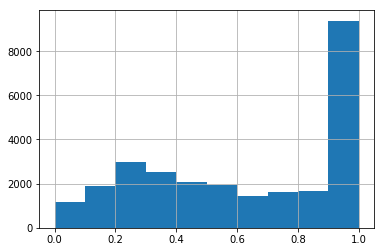

In [14]:
osm_routepoints = pd.read_csv("../data/osm_routepoints_for_matching.csv", dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)

gtfs_routepoints.fillna("", inplace=True)
gtfs_routepoints = gtfs_routepoints[gtfs_routepoints['gtfs_ZDEr_ID_REF_A'] != '']

#on fusionne sur les codes d'arrêts et les codes de lignes
routepoints = gtfs_routepoints.merge(
                    osm_routepoints, how='inner', 
                    right_on=["osm_osm:ref:FR:STIF", "osm_osm:ref:FR:STIF:ExternalCode_Line"],
                    left_on=["gtfs_ZDEr_ID_REF_A", "gtfs_route_id"]
               )
routepoints.fillna("", inplace=True)

def compute_similarity_for_terminus(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1.lower(), elem2.lower()).ratio()

def compute_similarity(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1, elem2).ratio()

#on fusionne sur les terminus de lignes
routepoints['destination_confidence'] = routepoints[['osm_destination','gtfs_dest_name']].apply(lambda x: compute_similarity_for_terminus(*x), axis=1)
routepoints['destination_confidence'].hist()

In [15]:
routepoints = routepoints[routepoints['destination_confidence'] >= 0.6]

NB : le matching sur les terminus est loin d'être parfait. Pour de meilleurs résultats, il faudrait :
* soit un référentiel officiel des parcours (qui pourrait être importé dans les données OSM)
* soit établir un tableau de correspondance entre les terminus

(cf quelques contrexemples ci-dessous)

In [16]:
difflib.SequenceMatcher(None, 'A. Lebrun', '').ratio() #0
difflib.SequenceMatcher(None, 'Sucy-Bonneuil RER', 'Gare de Sucy-Bonneuil').ratio() # 0.68
difflib.SequenceMatcher(None, 'Cimetière', 'Cimetière de Saint-Maur-des-Fossés').ratio() #0.41
difflib.SequenceMatcher(None, 'A. Lebrun', 'Auguste Lebrun').ratio() #0.69
difflib.SequenceMatcher(None, 'Saint-Maur Créteil', 'SAINT-MAUR - CRETEIL RER').ratio() #0.23
difflib.SequenceMatcher(None, 'Saint-Maur Créteil'.lower(), 'SAINT-MAUR - CRETEIL RER'.lower()).ratio() #0.80

difflib.SequenceMatcher(None, 'Gare de Laplace (Arcueil)', 'Arcueil Laplace RER').ratio() # 0.5
difflib.SequenceMatcher(None, 'Noisy-le-Roi - Centre Commercial le Cèdre', 'Centre commercial').ratio() #0.55
difflib.SequenceMatcher(None, 'Massy', 'Gare RER Massy Palaiseau').ratio() #0.34
difflib.SequenceMatcher(None, 'Gare de La Verrière', 'LA VERRIERE NOCTILIEN'.lower()).ratio() #0.4

0.4

## Mesures qualitatives

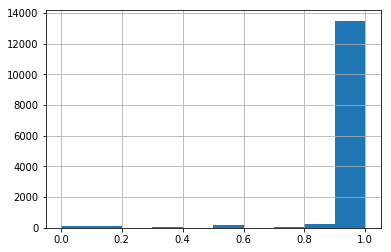

In [17]:
# différences sur les codes de ligne
routepoints['line_code_confidence'] = routepoints[['osm_code','gtfs_route_short_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['line_code_confidence'].hist()

In [18]:
routepoints_ = routepoints[routepoints['line_code_confidence'] < 0.8]
routepoints_ = routepoints_[['gtfs_route_short_name', 'osm_code']]
grouped = routepoints_.groupby(['gtfs_route_short_name', 'osm_code'])
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
unique_df = routepoints_.reindex(index)
unique_df

,gtfs_route_short_name,osm_code
21190,MONTBUS,526
0,CEN,Centaure
10138,CITA,Citalien
8608,RE,RÉ
21168,CHARONN,501
21178,BIEVRES,513
19868,ORLYBUS,Orlybus
21226,V1,v1
10248,DIRECT 4,Direct 4
21184,NEY-FLA,519


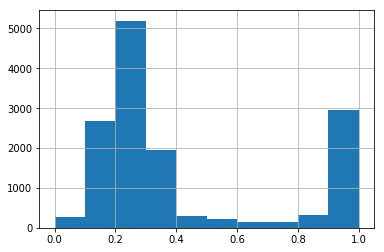

In [19]:
# différences sur les noms des arrêts
routepoints['name_confidence'] = routepoints[['osm_name','gtfs_stop_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['name_confidence'].hist()

In [20]:
routepoints_ = routepoints[routepoints['name_confidence'] < 0.5]
routepoints_ = routepoints_[['gtfs_stop_name', 'osm_name']]
grouped = routepoints_.groupby(['gtfs_stop_name', 'osm_name'])
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
unique_df = routepoints_.reindex(index)
unique_df.head()

,gtfs_stop_name,osm_name
14724,CUSTINE - RAMEY,Custine - Ramey
17728,PIERRE CURIE,Pierre Curie
8879,14 JUILLET,14 Juillet
19024,ALEXIS MARTIN,Alexis Martin
12551,TOLBIAC - BAUDRICOURT,Tolbiac - Baudricourt


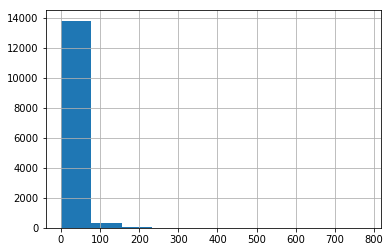

In [21]:
def compute_distance(row):
    dist = vincenty(
        (float(row['osm_lat']), float(row['osm_lon'])), 
        (float(row['gtfs_stop_lat']), float(row['gtfs_stop_lon']))
    )
    return dist.meters
   
routepoints['distance'] = routepoints.apply(compute_distance, axis=1)

routepoints['distance'].hist()
#TODO : trouver une meilleure représentation graphique qui montre que 
#l'essentiel est en dessous de 50 m, mais qu'il y a des points bien bien loin
# ptet une boite à moustache ?

In [22]:
routepoints['distance'].mean()

17.992747608595867

In [23]:
routepoints_ = routepoints[routepoints['distance'] > 80]
len(routepoints_)

350

In [24]:
routepoints_ = routepoints_.sort_values(by='distance') 
#TODO : trouver un moyen sympa de visualiser ces écarts de distance
routepoints_

,gtfs_stop_id,gtfs_route_id,gtfs_ZDEr_ID_REF_A,gtfs_stop_name,gtfs_stop_lat,gtfs_stop_lon,gtfs_wheelchair_boarding,gtfs_dest_name,gtfs_route_short_name,gtfs_agency_name,...,osm_lon,osm_osm:ref:FR:STIF:ExternalCode_Line,osm_code,osm_lat,osm_stop_id,osm_osm:ref:FR:STIF,destination_confidence,line_code_confidence,name_confidence,distance
18385,StopPoint:59:7275415,100100162:162,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,VAL FLEURY RER,162,RATP,...,2.3332596,100100162:162,162,48.797711799999995,StopPoint:Node:979833097,28582,0.800000,1.000000,0.210526,80.228791
18384,StopPoint:59:7275415,100100162:162,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,VAL FLEURY RER,162,RATP,...,2.3332596,100100162:162,162,48.797711799999995,StopPoint:Node:979833097,28582,0.800000,1.000000,0.210526,80.228791
18703,StopPoint:59:7275415,100100184:184,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,PASTEUR,184,RATP,...,2.3332596,100100184:184,184,48.797711799999995,StopPoint:Node:979833097,28582,0.636364,1.000000,0.210526,80.228791
18702,StopPoint:59:7275415,100100184:184,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,PASTEUR,184,RATP,...,2.3332596,100100184:184,184,48.797711799999995,StopPoint:Node:979833097,28582,0.636364,1.000000,0.210526,80.228791
21545,StopPoint:59:4016293,100987753:N51,24603,BROCHANT - CARDINET,48.891322,2.318669,1,GARE SAINT-LAZARE.,N51,Noctilien,...,2.3179000999999997,100987753:N51,N51,48.891836,StopPoint:Node:596079812,24603,0.971429,1.000000,0.263158,80.289990
23485,StopPoint:59:4016293,100987782:N15,24603,BROCHANT - CARDINET,48.891322,2.318669,1,VILLEJUIF - LOUIS ARAGON-METRO,N15,Noctilien,...,2.3179000999999997,100987782:N15,N15,48.891836,StopPoint:Node:596079812,24603,0.851852,1.000000,0.263158,80.289990
14318,StopPoint:59:4016293,100100074:74,24603,BROCHANT - CARDINET,48.891322,2.318669,1,PLACE DE CLICHY,74,RATP,...,2.3179000999999997,100100074:74,74,48.891836,StopPoint:Node:596079812,24603,1.000000,1.000000,0.263158,80.289990
14325,StopPoint:59:4016293,100100074:74,24603,BROCHANT - CARDINET,48.891322,2.318669,1,HOTEL DE VILLE,74,RATP,...,2.3179000999999997,100100074:74,74,48.891836,StopPoint:Node:596079812,24603,0.928571,1.000000,0.263158,80.289990
21546,StopPoint:59:4016293,100987753:N51,24603,BROCHANT - CARDINET,48.891322,2.318669,1,GARE SAINT-LAZARE.,N51,Noctilien,...,2.3179000999999997,100987753:N51,N51,48.891836,StopPoint:Node:596079812,24603,0.971429,1.000000,0.263158,80.289990
14324,StopPoint:59:4016293,100100074:74,24603,BROCHANT - CARDINET,48.891322,2.318669,1,HOTEL DE VILLE,74,RATP,...,2.3179000999999997,100100074:74,74,48.891836,StopPoint:Node:596079812,24603,0.928571,1.000000,0.263158,80.289990
